# **4. Data Analysis**


In [ ]:
#install and import pylibs
!pip install pylibs-ocean[shapefile,eof]
from pylib import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.6/395.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.4 MB/s eta 0:00:00


In [ ]:
#download training dataset
!rm *.txt *.zip *.nc *.csv *.dbf *.prj *sh? *.npz #clean existing data first
urlsave('https://docs.google.com/uc?export=download&id=1o6m70CuQr-vcTLLTc9EY_0cb3L_qkQQV','cybertrainingdata_2024.zip')
!unzip cybertrainingdata_2024.zip

rm: cannot remove '*.txt': No such file or directory
rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.nc': No such file or directory
rm: cannot remove '*.csv': No such file or directory
rm: cannot remove '*.dbf': No such file or directory
rm: cannot remove '*.prj': No such file or directory
rm: cannot remove '*sh?': No such file or directory
rm: cannot remove '*.npz': No such file or directory
Archive:  cybertrainingdata_2024.zip
  inflating: elev_model.npz          
  inflating: GEBCO.nc                
  inflating: JMSMH_10122020.csv      
  inflating: noaa_elev.npz           
  inflating: SFBay.dbf               
  inflating: SFBay.prj               
  inflating: SFBay.shp               
  inflating: SFBay.shx               
  inflating: SFBay_temp.npz          
  inflating: SFBayWQ.npz             
  inflating: USGS_flow_data.txt      
  inflating: USGS_flow.txt           
  inflating: YRK005.40_7312023.csv   


## **working with NOAA elevation data**
VIMS has an operational model that routinely makes prediction about water level along the US East Coast. In this section, I will use NOAA observational data and VIMS model result about water level to domonstrate different methods for data analysis.


In [ ]:
#Let's have a view about the data first
C=read('noaa_elev.npz')  #NOAA water levels along US East Coast
M=read('elev_model.npz')  #VIMS model result

#check data information
C.INFO, M.INFO

(['elev  : array(1519384,), float64',
  'lat   : array(1519384,), float64',
  'lon   : array(1519384,), float64',
  'station: array(1519384,), int32',
  'time  : array(1519384,), float64'],
 ['elev  : array(164, 1728), float64',
  'station: array(164,), int64',
  'time  : array(1728,), float64'])

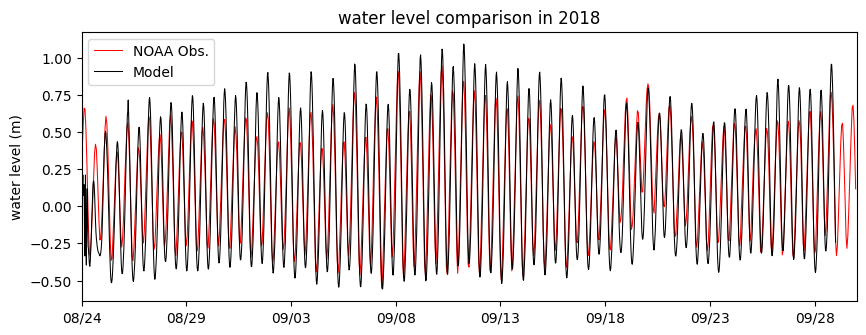

In [ ]:
#input
station=8449130
StartT=datenum(2018,8,24)
EndT=datenum(2018,9,30)

#get observation
fp=(C.station==station)*(C.time>=StartT)*(C.time<EndT)
oti,oyi=C.time[fp],C.elev[fp]

#get model result
fp=nonzero(M.station==station)[0][0]
mti=M.time; myi=M.elev[fp]

#model-observation comparison
figure(figsize=[10,3.5])
plot(oti,oyi,'r-', mti,myi,'k-',lw=0.75)

#annotation
xts,xls=get_xtick(fmt=1,xts=arange(StartT,EndT+1),str='%m/%d'); xts,xls=xts[::5],xls[::5]
setp(gca(),xticks=xts,xticklabels=xls,xlim=[StartT,EndT])
legend(['NOAA Obs.','Model'])
title('water level comparison in 2018')
ylabel('water level (m)');

## **4.1 Statistics**

Below are the frequently used statistics in Marine Science Research

**R**: Correlation Coefficient

**ME**: Mean Error

**MAE**: Mean Absolute Error

**RMSD**: Root Mean Square Deviation

**MS**: Model Skill

### **4.1.1 interpolation**

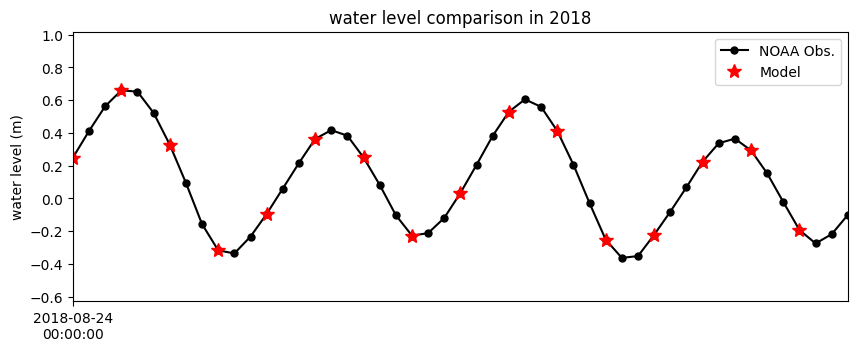

In [ ]:
#interpolate at 3-hour interval
sti=arange(datenum(2018,8,24), datenum(2018,8,26), 3/24)
syi=interpolate.interp1d(oti,oyi)(sti) #(soyi, myi) are data pairs

figure(figsize=[10,3.5])
plot(oti,oyi,'k.-',ms=10);
plot(sti,syi,'r*',ms=10)

#annotation
add_xtick()
setp(gca(),xlim=[datenum(2018,8,24), datenum(2018,8,26)])
legend(['NOAA Obs.','Model'])
title('water level comparison in 2018')
ylabel('water level (m)');

### **4.1.2 work with function get_stat**


Text(0.5, 1.0, 'water level (m)')

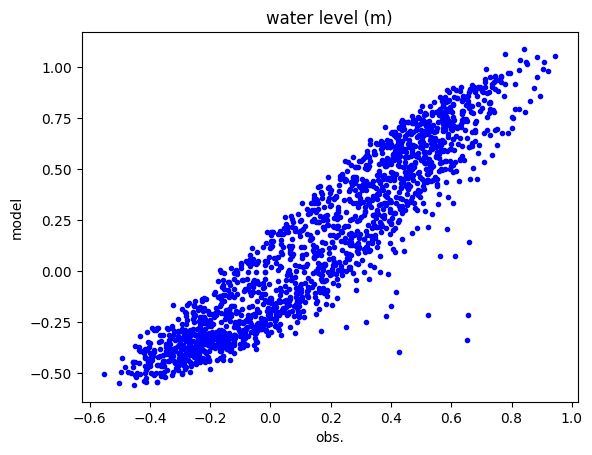

In [ ]:
#get data pairs (interpolation)
soyi=interpolate.interp1d(oti,oyi)(mti) #(soyi, myi) are data pairs

#scatter plot
plot(soyi,myi,'b.')
xlabel('obs.'); ylabel('model'); title('water level (m)')

In [ ]:
#get statistics
S=get_stat(myi,soyi)
print('R={}\nME={}\nMAE={}\nRMSD={}\nMS={}'.format(S.R,S.ME,S.MAE,S.RMSD,S.ms))

R=0.9293932490289009
ME=-0.021861921925815004
MAE=0.1388046289730061
RMSD=0.1675901844206002
MS=0.9493390928857309


## **4.2 low-pass filter**
In pylib, function **`lpfilt`** is used to do low-pass filter analysis.

Text(0, 0.5, 'water level (m)')

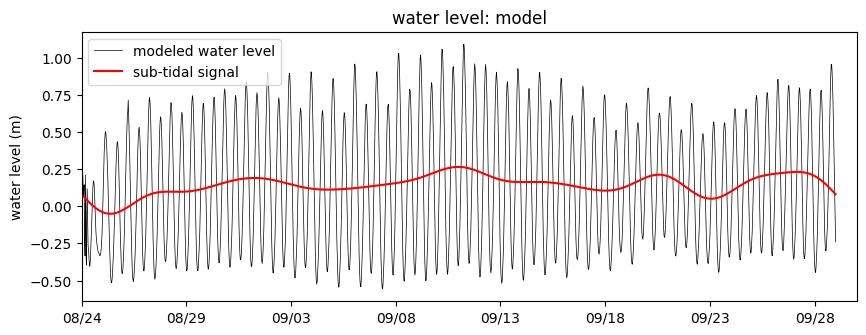

In [ ]:
figure(figsize=[10,3.5])

#plot model result
plot(mti,myi,'k-',lw=0.5)

#plot low-pass filter results
fmyi=lpfilt(myi,1/48,0.25)
plot(mti,fmyi,'r-')

#annotation
xts,xls=get_xtick(fmt=1,xts=arange(StartT,EndT+1),str='%m/%d'); xts,xls=xts[::5],xls[::5]
setp(gca(),xticks=xts,xticklabels=xls,xlim=[StartT,EndT]);
legend(['modeled water level','sub-tidal signal'])
title('water level: model')
ylabel('water level (m)')

## **4.3 data smoothing**

In pylib, function **`smooth`** is used to do smooth analysis.

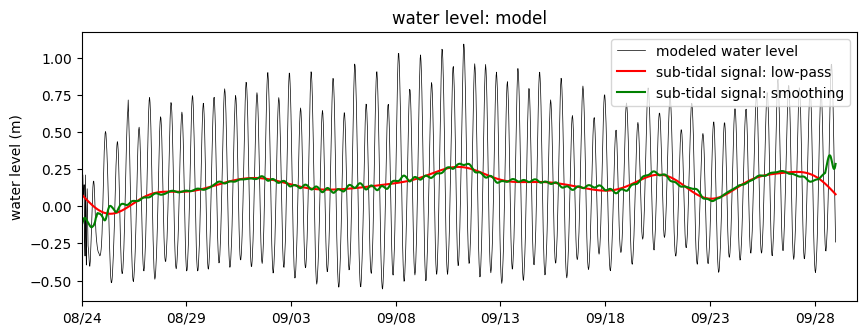

In [ ]:
figure(figsize=[10,3.5])

#plot model result
plot(mti,myi,'k-',lw=0.5)

#plot low-pass filter results
fmyi=lpfilt(myi,1/48,0.25)
plot(mti,fmyi,'r-')

#plot data smoothing results
smyi=smooth(myi,48);
plot(mti,smyi,'g-')

#annotation
xts,xls=get_xtick(fmt=1,xts=arange(StartT,EndT+1),str='%m/%d'); xts,xls=xts[::5],xls[::5]
setp(gca(),xticks=xts,xticklabels=xls,xlim=[StartT,EndT]);
legend(['modeled water level','sub-tidal signal: low-pass','sub-tidal signal: smoothing'])
title('water level: model')
ylabel('water level (m)');

## **4.4 FFT**

In pylib, function **`mfft`** is used to do fft analysis.

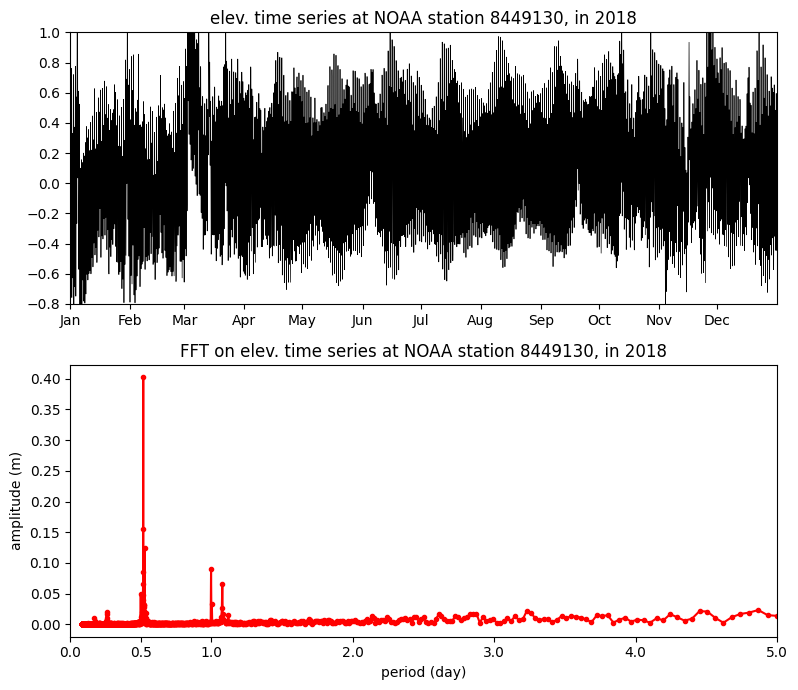

In [ ]:
#usage of FFT

#get data at noaa station 8410140
fp=(C.station==8449130)*(C.time>=datenum(2018,1,1))*(C.time<datenum(2019,1,1))
oti,oyi=C.time[fp],C.elev[fp]

Period,Amp,Phase=mfft(oyi,1/24)

#plot
figure(figsize=[8,7])

subplot(2,1,1)
xts,xls=get_xtick(fmt=1,xts=[2018,2018],str='%b')
plot(oti,oyi,'k-',lw=0.5)
setp(gca(),xticks=xts,xticklabels=xls,xlim=[datenum(2018,1,1),datenum(2019,1,1)],ylim=[-0.8,1.0])
title('elev. time series at NOAA station 8449130, in 2018');

subplot(2,1,2)
plot(Period, Amp,'r.-')
setp(gca(),xticks=[0,0.5,*arange(1,6)],xlim=[0,5]);
xlabel('period (day)'); ylabel('amplitude (m)')
title('FFT on elev. time series at NOAA station 8449130, in 2018');
gcf().tight_layout()

## **4.5 Regression**

In pylib, function **`lsq`** is used to do regression.

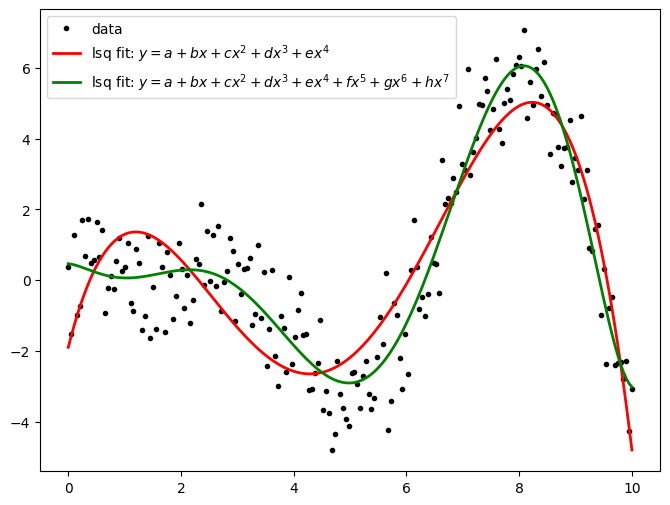

In [ ]:
#fake some data
npt=200; x=linspace(0,10,npt)
y=randn(npt)+abs(x-2)*sin(x)

#use function y=a+b*x+c*x^2+d*x^3+e*x^4 to fit the data
AA=c_[ones(npt),x,x**2,x**3,x**4]  #this is the matrix for each term of fit function
CC1,fy1=lsq(AA,y)

#use function y=a+b*x+c*x^2+d*x^3+e*x^4+f*x^5+g*x^6+h*x^7 to fit the data
AA=c_[ones(npt),x,x**2,x**3,x**4,x**5,x**6,x**7] #try much higher polynomial
CC2,fy2=lsq(AA,y)

#plot
figure(figsize=[8,6])
plot(x,y,'k.')
plot(x,fy1,'r',lw=2)
plot(x,fy2,'g',lw=2)
legend(['data',r'lsq fit: $y=a+bx+cx^2+dx^3+ex^4$',r'lsq fit: $y=a+bx+cx^2+dx^3+ex^4+fx^5+gx^6+hx^7$'],loc=2,fontsize=10)

## **5.5 EOF (Empirical Orthogonal Function) analysis**

* In pylib, function **`EOF`** is used to do EOF analysis.

* Need to install `eofs` package that **`EOF`** depends on.

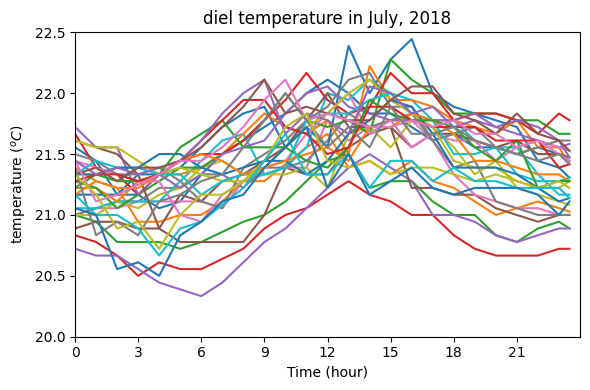

In [ ]:
#read San Francisco Bay temp in July, 2018
C=read('SFBay_temp.npz')

#plot diel temperature in July, 2018
figure(figsize=[6,4])
plot(C.hour,C.temp.T)
setp(gca(),xticks=arange(0,24,3),yticks=arange(20,23,0.5),xlim=[0,24],ylim=[20,22.5])
xlabel('Time (hour)'); ylabel(r'temperature $(^{o}C$)')
title('diel temperature in July, 2018')
gcf().tight_layout();


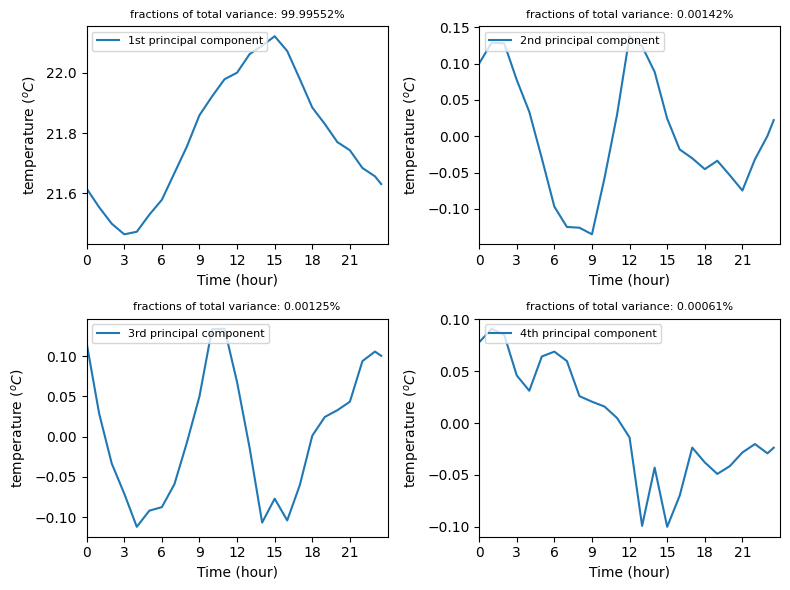

In [ ]:
#EOF analysis
(PC,CC,VC,solver)=EOF(C.temp,4)

figure(figsize=[8,6])
tags=['1st','2nd','3rd','4th']
for i in arange(4):
    subplot(2,2,i+1)
    plot(C.hour,PC[i])
    setp(gca(),xticks=arange(0,24,3),xlim=[0,24])
    xlabel('Time (hour)'); ylabel(r'temperature $(^{o}C$)')
    legend(['{} principal component'.format(tags[i])],loc=2,fontsize=8)
    title('fractions of total variance: {:0.5f}%'.format(100*VC[i]),fontsize=8)
gcf().tight_layout()


## **5.6 Harmonic Analysis**

Dr. Qianqian Liu will introduce `ttide` package to do harmonic_analysis. FYI, in pylib, function **`harmonic_analysis`** is used to do harmonic_analysis.

## **5.7 Geometry Computing**

### **5.7.1 Computing contour lines**


extracting contours in subdomain: 1/1


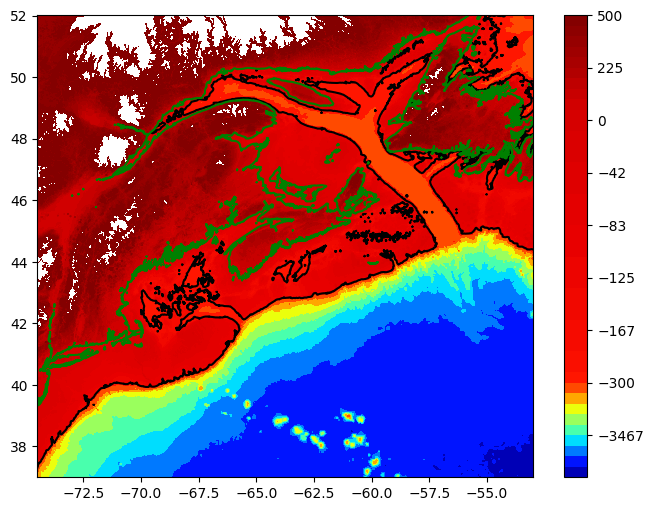

In [ ]:
#read DEM data
C=ReadNC('GEBCO.nc',2)

#compute contours
levels=[-200,0]
S=compute_contour(C.lon,C.lat,C.elev,levels,fname='GEBCO_contour')

#plots contour lines
levels=[*linspace(-6000,-300,10),*linspace(-200,0,25),*linspace(5,500,10)]
figure(figsize=[8,6]); set_cmap('jet')
contourf(C.lon,C.lat,C.elev,levels=levels,vmin=-6e3,vmax=500)
x,y=S.xy[0].T; plot(x,y,'k-')
x,y=S.xy[1].T; plot(x,y,'g-')
colorbar()

### **5.7.2 find the nearest points**

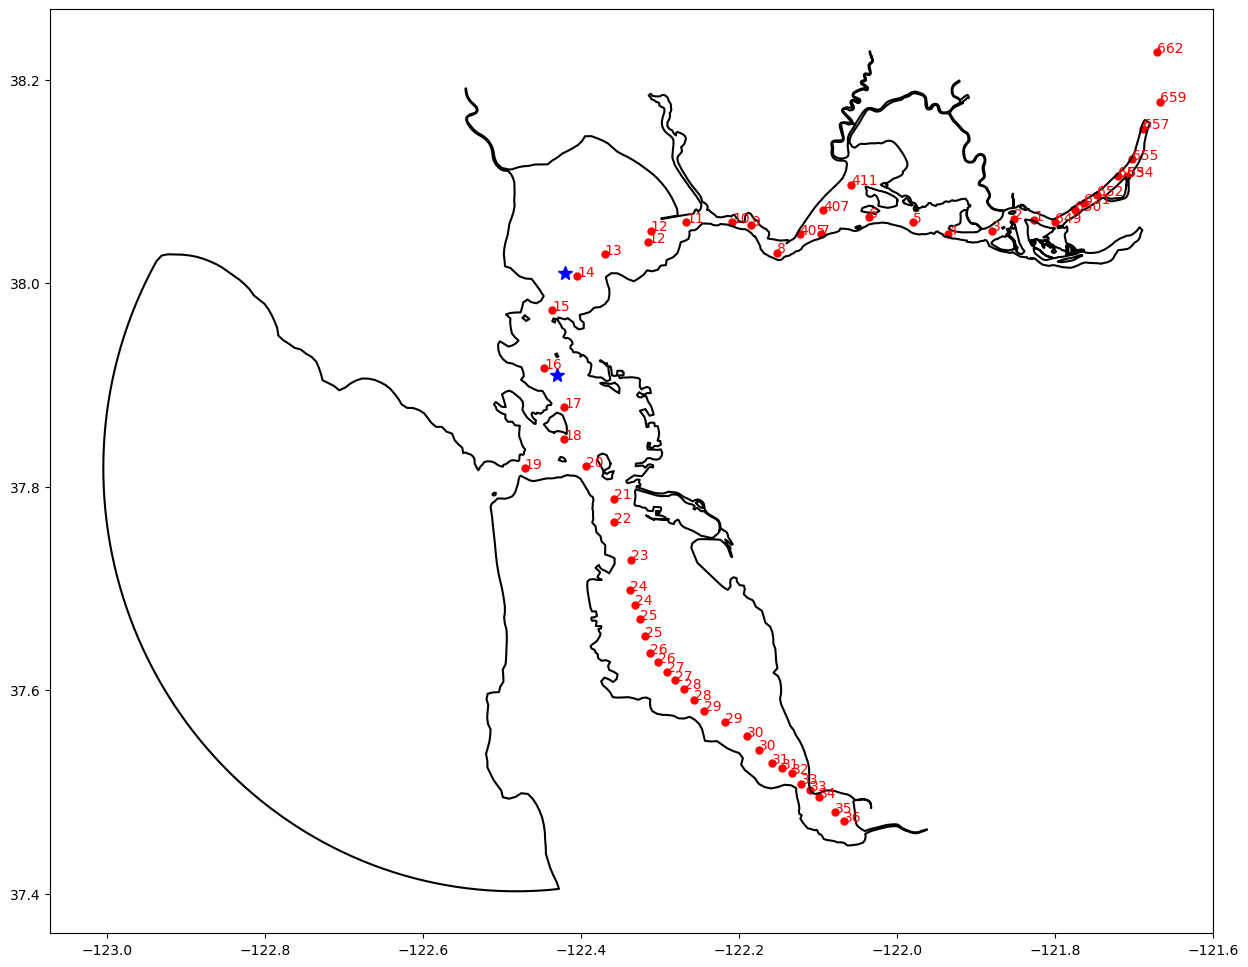

In [ ]:
#Problem: find the nearest SFBay stations for these two points
mx=array([-122.43,-122.42])
my=array([37.91,38.01])

#-------------------------------------------------------------------------------
#plot SFBay stations
S=read('SFBay.shp')  #SFBay boundary
C=read('SFBayWQ.npz') #SFBay water quality

#plot SFBay stations
figure(figsize=[15,12])

#my points
mx=array([-122.43,-122.42])
my=array([37.91,38.01])
plot(mx,my,'b*',ms=10)

#plot stations
stations=unique(C.station)
xs,ys=array([[C.lon[i],C.lat[i]] for i in stations]).T
plot(xs,ys,'r.',ms=10)
for x,y,station in zip(xs,ys,stations): text(x,y,str(int(station)),color='r')

#plot SFBay boundary
plot(*S.xy.T,'k') #same as plot(S.xy[:,0],S.xy[:,1],'k')
#-------------------------------------------------------------------------------


In [ ]:
#use near_pts
ind=near_pts(c_[mx,my],c_[xs,ys])
stations[ind]

array([16., 14.])

### **5.7.3 find points inside a polygon**

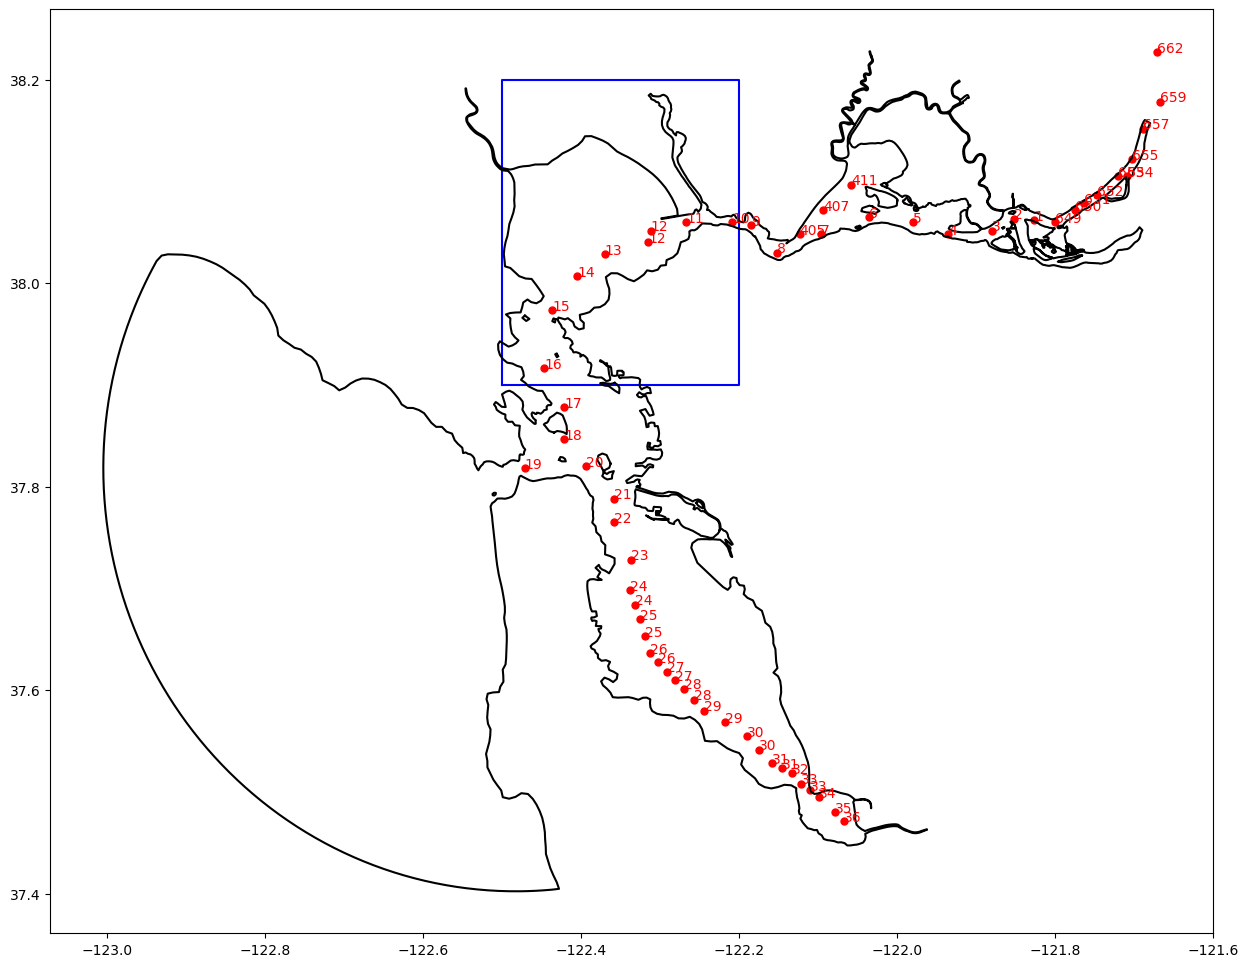

In [ ]:
#find all the stations in the following region
xm=[-122.5,-122.2]
ym=[37.9,38.2]


#-------------------------------------------------------------------------------
#plot stations and box
#-------------------------------------------------------------------------------
#plot SFBay stations
S=read('SFBay.shp')  #SFBay boundary
C=read('SFBayWQ.npz') #SFBay water quality

#plot SFBay stations
figure(figsize=[15,12])

#my points
plot([xm[0],xm[1],xm[1],xm[0],xm[0]],[ym[0],ym[0],ym[1],ym[1],ym[0]],'b-')

#plot stations
stations=unique(C.station)
xs,ys=array([[C.lon[i],C.lat[i]] for i in stations]).T
plot(xs,ys,'r.',ms=10)
for x,y,station in zip(xs,ys,stations): text(x,y,str(int(station)),color='r')

#plot SFBay boundary
plot(*S.xy.T,'k') #same as plot(S.xy[:,0],S.xy[:,1],'k')
#-------------------------------------------------------------------------------

In [ ]:
#use pylibs function: inside_polygon
px=array([xm[0],xm[1],xm[1],xm[0]])
py=array([ym[0],ym[0],ym[1],ym[1]])

ind=inside_polygon(c_[xs,ys],px,py)
stations[ind==1]

array([10. , 11. , 12. , 12.5, 13. , 14. , 15. , 16. ])

## **Excercise 4**

Filter the database `SFBayWQ.npz`, and use `temperature (temp)` at station 657 to fit `dissolved oxygen (DO)` from at station 657 from 2010 to 2020 with formulation: **`DO=a+b*temp`**.

Then, plot `DO` obsevation and 'DO' prediciton, and annoation the plot with the statsitics. After you finish the plotting, try to answer how `temperature` affects the diel variation of 'Dissolved Oxygen' based on your results.

In [ ]:
#Type your answer 4 here